In [83]:
!pip install tensorflow==2.10.0

In [84]:
! python -V

Python 3.10.12


In [85]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np

In [86]:
tf.__version__

'2.10.0'

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
# 시드 값 설정
SEED = 50

# 시드 고정
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [164]:
normal_dir = '/content/drive/MyDrive/캡스톤/Data_2/Normal'
abnormal_dir = '/content/drive/MyDrive/캡스톤/Data_2/Abnormal'

# 이미지 파일 리스트 생성
normal_images = [os.path.join(normal_dir, fname) for fname in os.listdir(normal_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
abnormal_images = [os.path.join(abnormal_dir, fname) for fname in os.listdir(abnormal_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

# 데이터 셋 셔플
random.shuffle(normal_images)
random.shuffle(abnormal_images)

# 정상 데이터 분할
normal_train, normal_temp = train_test_split(normal_images, test_size=0.3, random_state=42)
normal_val, normal_test = train_test_split(normal_temp, test_size=0.5, random_state=42)

# 비정상 데이터 분할
abnormal_train, abnormal_temp = train_test_split(abnormal_images, test_size=0.3, random_state=42)
abnormal_val, abnormal_test = train_test_split(abnormal_temp, test_size=0.5, random_state=42)

# 데이터셋 통합
train_data = normal_train + abnormal_train
train_labels = [0] * len(normal_train) + [1] * len(abnormal_train)

val_data = normal_val + abnormal_val
val_labels = [0] * len(normal_val) + [1] * len(abnormal_val)

test_data = normal_test + abnormal_test
test_labels = [0] * len(normal_test) + [1] * len(abnormal_test)

# 데이터셋 섞기
train_dataset = list(zip(train_data, train_labels))
random.shuffle(train_dataset)
train_data, train_labels = zip(*train_dataset)

val_dataset = list(zip(val_data, val_labels))
random.shuffle(val_dataset)
val_data, val_labels = zip(*val_dataset)

test_dataset = list(zip(test_data, test_labels))
random.shuffle(test_dataset)
test_data, test_labels = zip(*test_dataset)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
])

def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image.set_shape([None, None, 3])  # 이미지의 shape을 명시적으로 설정
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image)
    return image, label

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def load_data(data, labels, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((list(data), list(labels)))
    # ds = ds.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = configure_for_performance(ds)
    return ds

# 데이터셋 생성
batch_size = 64
EPOCH = 80

train_ds = load_data(train_data, train_labels, batch_size)
val_ds = load_data(val_data, val_labels, batch_size)
test_ds = load_data(test_data, test_labels, batch_size)



기존코드

In [165]:
# normal_dir = '/content/drive/MyDrive/캡스톤/Data_2/Normal'
# abnormal_dir = '/content/drive/MyDrive/캡스톤/Data_2/Abnormal'

# # 이미지 파일 리스트 생성
# normal_images = [os.path.join(normal_dir, fname) for fname in os.listdir(normal_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
# abnormal_images = [os.path.join(abnormal_dir, fname) for fname in os.listdir(abnormal_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

# # 데이터 셋 셔플
# random.shuffle(normal_images)
# random.shuffle(abnormal_images)

# # 정상 데이터 분할
# normal_train, normal_temp = train_test_split(normal_images, test_size=0.3, random_state=42)
# normal_val, normal_test = train_test_split(normal_temp, test_size=0.5, random_state=42)

# # 비정상 데이터 분할
# abnormal_train, abnormal_temp = train_test_split(abnormal_images, test_size=0.3, random_state=42)
# abnormal_val, abnormal_test = train_test_split(abnormal_temp, test_size=0.5, random_state=42)

# # 데이터셋 통합
# train_data = normal_train + abnormal_train
# train_labels = [0] * len(normal_train) + [1] * len(abnormal_train)

# val_data = normal_val + abnormal_val
# val_labels = [0] * len(normal_val) + [1] * len(abnormal_val)

# test_data = normal_test + abnormal_test
# test_labels = [0] * len(normal_test) + [1] * len(abnormal_test)

# # 데이터셋 섞기
# train_dataset = list(zip(train_data, train_labels))
# random.shuffle(train_dataset)
# train_data, train_labels = zip(*train_dataset)

# val_dataset = list(zip(val_data, val_labels))
# random.shuffle(val_dataset)
# val_data, val_labels = zip(*val_dataset)

# test_dataset = list(zip(test_data, test_labels))
# random.shuffle(test_dataset)
# test_data, test_labels = zip(*test_dataset)


# def preprocess_image(image_path):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_image(image, channels=3)
#     image.set_shape([256, 256, 3])  # 이미지의 shape을 명시적으로 설정
#     image = tf.image.resize(image, [256, 256])
#     image = tf.cast(image, tf.float32) / 255.0
#     return image

# def configure_for_performance(ds):
#     ds = ds.cache()
#     ds = ds.shuffle(buffer_size=1000)
#     ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#     return ds

# def load_data(data, labels, batch_size):
#     ds = tf.data.Dataset.from_tensor_slices((list(data), list(labels)))
#     ds = ds.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
#     ds = ds.batch(batch_size)
#     ds = configure_for_performance(ds)
#     return ds

# # 데이터셋 생성
# batch_size = 64
# EPOCH = 80

# train_ds = load_data(train_data, train_labels, batch_size)
# val_ds = load_data(val_data, val_labels, batch_size)
# test_ds = load_data(test_data, test_labels, batch_size)

In [166]:
def build_unet(input_shape, num_classes, dropout_rate=0.3, l1_factor=0.01, l2_factor=0.01):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
                kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))(inputs)
    b1 = BatchNormalization()(c1)
    d1 = Dropout(dropout_rate)(b1)
    p1 = MaxPooling2D((2, 2))(d1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
                kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))(p1)
    b2 = BatchNormalization()(c2)
    d2 = Dropout(dropout_rate)(b2)
    p2 = MaxPooling2D((2, 2))(d2)

    # Bottleneck
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
                kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))(p2)
    b3 = BatchNormalization()(c3)
    d3 = Dropout(dropout_rate)(b3)

    # Decoder
    u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same',
                         kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))(d3)
    u4 = concatenate([u4, d2])
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    b4 = BatchNormalization()(c4)
    d4 = Dropout(dropout_rate)(b4)

    u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same',
                         kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))(d4)
    u5 = concatenate([u5, d1])
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    b5 = BatchNormalization()(c5)
    d5 = Dropout(dropout_rate)(b5)

    # 전역 평균 풀링과 밀집 레이어로 분류기 추가
    gap = GlobalAveragePooling2D()(d5)
    outputs = Dense(num_classes, activation='softmax')(gap)  # 클래스 수에 따라 수정

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

# # # 조기 종료와 학습률 감소 콜백
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)



# 모델 생성 및 컴파일
model = build_unet((256, 256, 3), num_classes=2)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

기존 코드

In [167]:
# def build_unet(input_shape, num_classes, dropout_rate=0.3, l1_factor=0.01, l2_factor=0.01):
#     inputs = Input(input_shape)

#     # Encoder
#     c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
#                 kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))(inputs)
#     b1 = BatchNormalization()(c1)
#     d1 = Dropout(dropout_rate)(b1)
#     p1 = MaxPooling2D((2, 2))(d1)

#     c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
#                 kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))(p1)
#     b2 = BatchNormalization()(c2)
#     d2 = Dropout(dropout_rate)(b2)
#     p2 = MaxPooling2D((2, 2))(d2)

#     # Bottleneck
#     c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
#                 kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))(p2)
#     b3 = BatchNormalization()(c3)
#     d3 = Dropout(dropout_rate)(b3)

#     # Decoder
#     u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same',
#                          kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))(d3)
#     u4 = concatenate([u4, d2])
#     c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
#     b4 = BatchNormalization()(c4)
#     d4 = Dropout(dropout_rate)(b4)

#     u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same',
#                          kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))(d4)
#     u5 = concatenate([u5, d1])
#     c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
#     b5 = BatchNormalization()(c5)
#     d5 = Dropout(dropout_rate)(b5)

#     # 전역 평균 풀링과 밀집 레이어로 분류기 추가
#     gap = GlobalAveragePooling2D()(d5)
#     outputs = Dense(num_classes, activation='softmax')(gap)  # 클래스 수에 따라 수정

#     model = Model(inputs=[inputs], outputs=[outputs])
#     return model

# # 클래스 가중치 계산
# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
# class_weights_dict = dict(enumerate(class_weights))


# # 모델 생성 및 컴파일
# model = build_unet((256, 256, 3), num_classes=2)
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [168]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCH, class_weight=class_weights_dict)

Epoch 1/80
11/11 [==============================] - 23s 2s/step - loss: 26.5563 - accuracy: 0.8931 - val_loss: 24.7007 - val_accuracy: 0.3154
Epoch 2/80
11/11 [==============================] - 17s 2s/step - loss: 22.5417 - accuracy: 0.9364 - val_loss: 20.8738 - val_accuracy: 0.9329
Epoch 3/80
11/11 [==============================] - 17s 2s/step - loss: 19.0946 - accuracy: 0.9523 - val_loss: 17.5871 - val_accuracy: 0.7987
Epoch 4/80
11/11 [==============================] - 17s 2s/step - loss: 16.0380 - accuracy: 0.9566 - val_loss: 14.7730 - val_accuracy: 0.7919
Epoch 5/80
11/11 [==============================] - 17s 2s/step - loss: 13.3886 - accuracy: 0.9566 - val_loss: 12.3735 - val_accuracy: 0.7852
Epoch 6/80
11/11 [==============================] - 17s 2s/step - loss: 11.0552 - accuracy: 0.9595 - val_loss: 10.2474 - val_accuracy: 0.7852
Epoch 7/80
11/11 [==============================] - 17s 2s/step - loss: 9.0504 - accuracy: 0.9624 - val_loss: 8.4417 - val_accuracy: 0.7852
Epoch 8/

In [169]:
model.evaluate(test_ds)

3/3 [==============================] - 1s 240ms/step - loss: 0.2359 - accuracy: 0.9799


[0.23586124181747437, 0.9798657894134521]

In [170]:
history.params
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [171]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

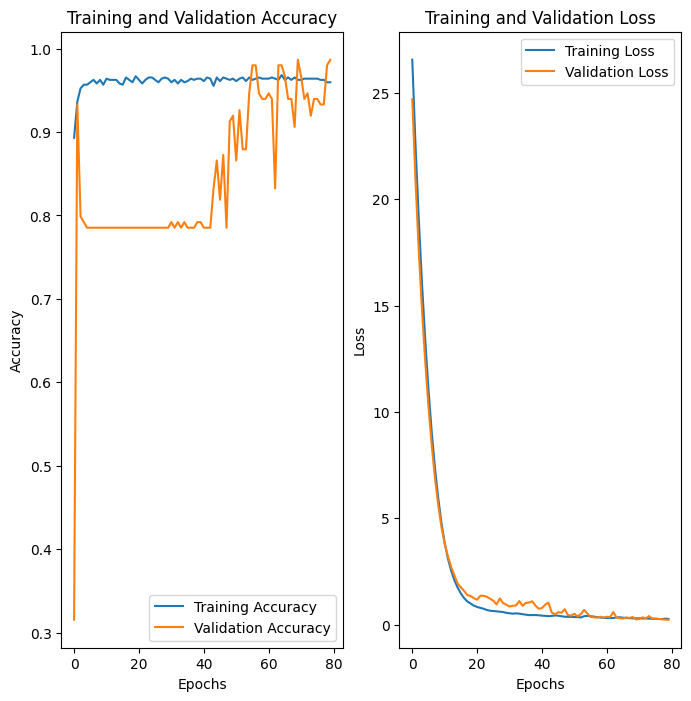

In [172]:
plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label='Training Accuracy')
plt.plot(range(EPOCH), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label='Training Loss')
plt.plot(range(EPOCH), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


plt.show()

In [175]:
model.save('trained_model_Unet_1.h5')

In [176]:
from google.colab import files
files.download('trained_model_Unet_1.h5')  # from colab to browser download

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>